# Information spread and influence Maximization in social networks


In this notebook we will explore the network of Game of Thrones characters and simulate information spread and influence maximization in the network.

In [1]:
%matplotlib inline
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import warnings
from collections import Counter
import sys
import os
from __future__ import division
plt.rcParams["figure.figsize"] = (20,10)
import tqdm as tqdm

warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

### Game of thrones network

![](images/got.png)

Andrew J. Beveridge, an associate professor of mathematics at Macalester College, and Jie Shan, an undergraduate created a network from the book A Storm of Swords by extracting relationships between characters to find out the most important characters in the book(or GoT).

The dataset is publicly avaiable for the 5 books at https://github.com/mathbeveridge/asoiaf. This is an interaction network and were created by connecting two characters whenever their names (or nicknames) appeared within 15 words of one another in one of the books. The edge weight corresponds to the number of interactions.

Credits:

Blog: https://networkofthrones.wordpress.com

Math Horizons Article: https://www.maa.org/sites/default/files/pdf/Mathhorizons/NetworkofThrones%20%281%29.pdf

Mridul Seth: https://github.com/MridulS/pydata-networkx/


##### Let's load in the datasets

In [2]:
books = []
for i in range(5):
    books.append(pd.read_csv('data/asoiaf-book{}-edges.csv'.format(i+1)))

In [3]:
all_books = pd.concat(books)

In [4]:
all_books.head()

Source              Target        Type  weight  \
0                   Addam-Marbrand     Jaime-Lannister  Undirected       3   
1                   Addam-Marbrand     Tywin-Lannister  Undirected       6   
2                Aegon-I-Targaryen  Daenerys-Targaryen  Undirected       5   
3                Aegon-I-Targaryen        Eddard-Stark  Undirected       4   
4  Aemon-Targaryen-(Maester-Aemon)      Alliser-Thorne  Undirected       4   

   book  
0   1.0  
1   1.0  
2   1.0  
3   1.0  
4   1.0

### we will sum all the books into a single edge between characters

In [5]:
edges = all_books.groupby(['Source','Target']).agg({'weight':'sum'}).reset_index()

In [6]:
edges.sort_values('weight',ascending=False).head()

Source            Target  weight
1334       Eddard-Stark  Robert-Baratheon     334
2031           Jon-Snow     Samwell-Tarly     228
1965  Joffrey-Baratheon       Sansa-Stark     222
1972  Joffrey-Baratheon  Tyrion-Lannister     219
640          Bran-Stark             Hodor     209

In [7]:
GOT = nx.from_pandas_edgelist(edges, 
                            source='Source',
                            target='Target',
                            edge_attr='weight' )

In [8]:
print(nx.info(GOT))

Name: 
Type: Graph
Number of nodes: 796
Number of edges: 2823
Average degree:   7.0930


In [9]:
weighted_degrees = dict(nx.degree(GOT,weight='weight'))
max_degree = max(weighted_degrees.values())

In [10]:
import seaborn as sns

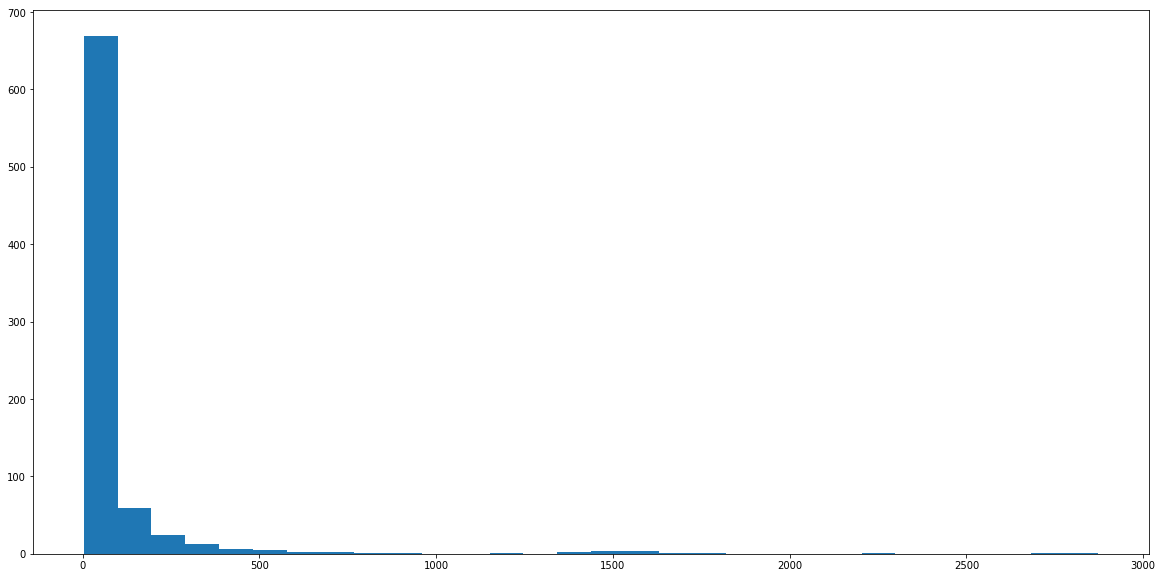

In [11]:
h = plt.hist(weighted_degrees.values(), bins = 30)

### Let's focus on the subnetwork of the key characters:

In [12]:
subG = GOT.subgraph([n for n in weighted_degrees if weighted_degrees[n]>200])

In [13]:
print(nx.info(subG))

Name: 
Type: SubGraph
Number of nodes: 63
Number of edges: 496
Average degree:  15.7460


In [14]:
pos = nx.spring_layout(subG,weight='weight',iterations=20, k = 4)

Plot the network:

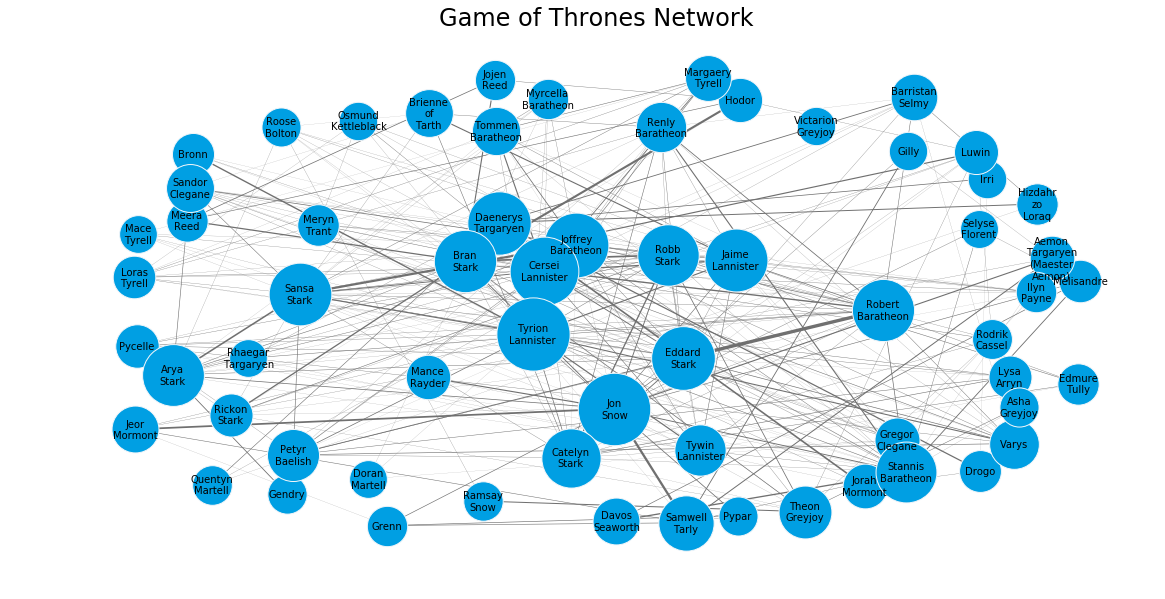

In [15]:
plt.axis('off')
plt.title('Game of Thrones Network',fontsize = 24)


for node in subG.nodes():
    size = 100*weighted_degrees[node]**0.5
    ns = nx.draw_networkx_nodes(subG,pos,nodelist=[node], node_size=size, node_color='#009fe3')
    ns.set_edgecolor('#f2f6fa')

nx.draw_networkx_labels(subG,pos,{n:n.replace('-','\n') for n in subG.nodes() if weighted_degrees[n]>100},font_size=10);

for e in subG.edges(data=True):
    if e[2]['weight']>10:
        nx.draw_networkx_edges(subG,pos,[e],width=e[2]['weight']/100,edge_color='#707070')

In [16]:
infection_times = {}

### Simulate independent cascade:

In [17]:
def independent_cascade(G,t,infection_times):
    #doing a t->t+1 step of independent_cascade simulation
    #each infectious node infects neigbors with probabilty proportional to the weight
    max_weight = max([e[2]['weight'] for e in G.edges(data=True)])
    current_infectious = [n for n in infection_times if infection_times[n]==t]
    for n in current_infectious:
        for v in G.neighbors(n):
            if v not in infection_times:
                if  G.get_edge_data(n,v)['weight'] >= np.random.random()*max_weight:
                    infection_times[v] = t+1
    return infection_times

In [18]:
def plot_G(G,pos,infection_times,t):
    current_infectious = [n for n in infection_times if infection_times[n]==t]
    plt.figure()
    plt.axis('off')
    plt.title('Game of Thrones Network, t={}'.format(t),fontsize = 24)

    for node in G.nodes():
        size = 100*weighted_degrees[node]**0.5
        if node in current_infectious:
            ns = nx.draw_networkx_nodes(G,pos,nodelist=[node], node_size=size, node_color='#feba02')
        elif infection_times.get(node,9999999)<t:
            ns = nx.draw_networkx_nodes(G,pos,nodelist=[node], node_size=size, node_color='#f2f6fa')
        else:
            ns = nx.draw_networkx_nodes(G,pos,nodelist=[node], node_size=size, node_color='#009fe3')
        ns.set_edgecolor('#f2f6fa')
    nx.draw_networkx_labels(G,pos,{n:n.replace('-','\n') for n in G.nodes() if weighted_degrees[n]>100},font_size=10);

    for e in G.edges(data=True):
        if e[2]['weight']>10:
            nx.draw_networkx_edges(G,pos,[e],width=e[2]['weight']/100,edge_color='#707070')


### Suppose Bran and Sam told Jon a secret. Who will find out about it?

In [19]:
infection_times = {'Bran-Stark':-1,'Samwell-Tarly':-1,'Jon-Snow':0}

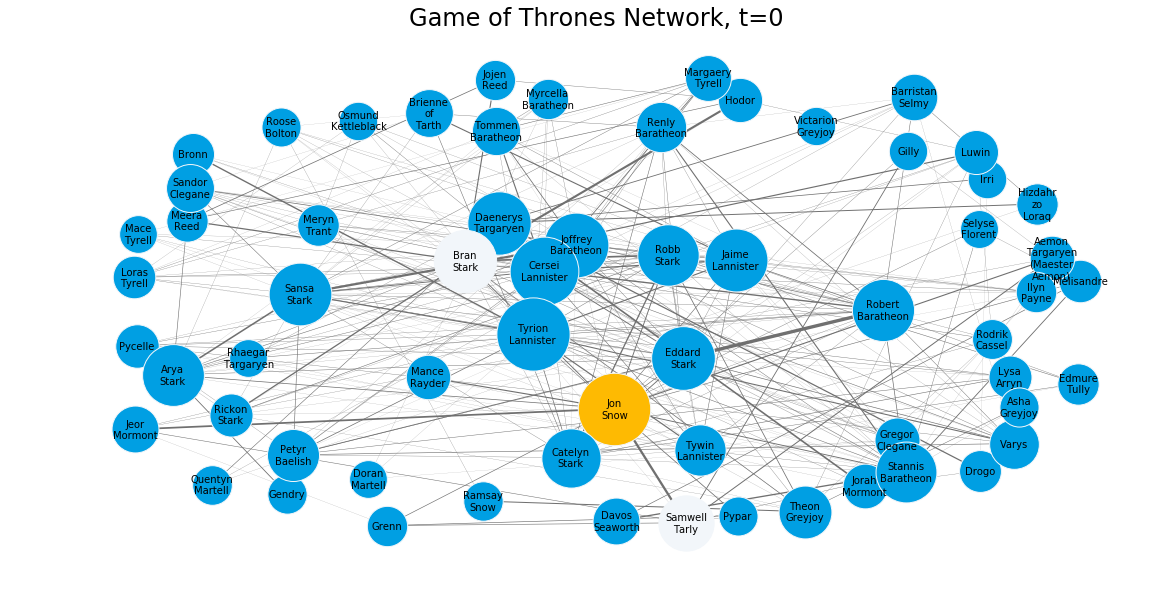

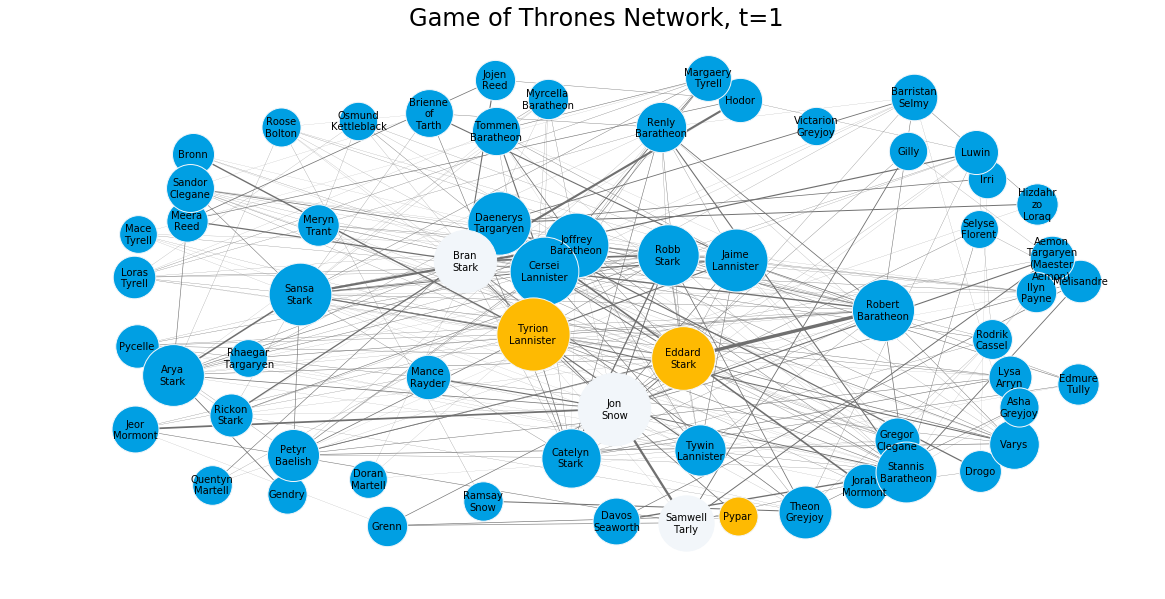

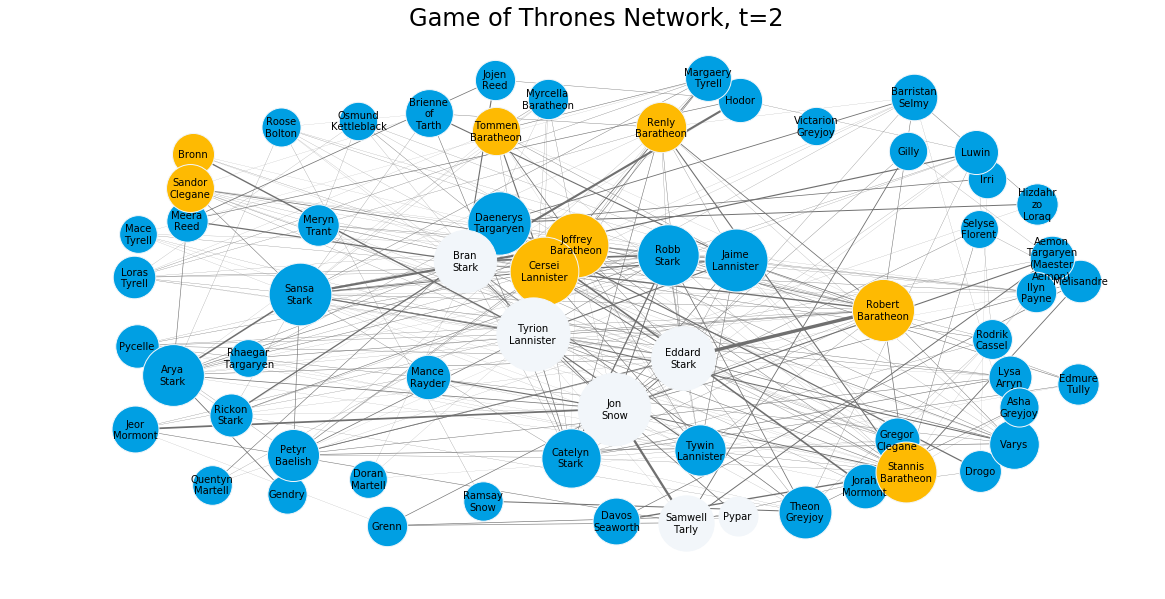

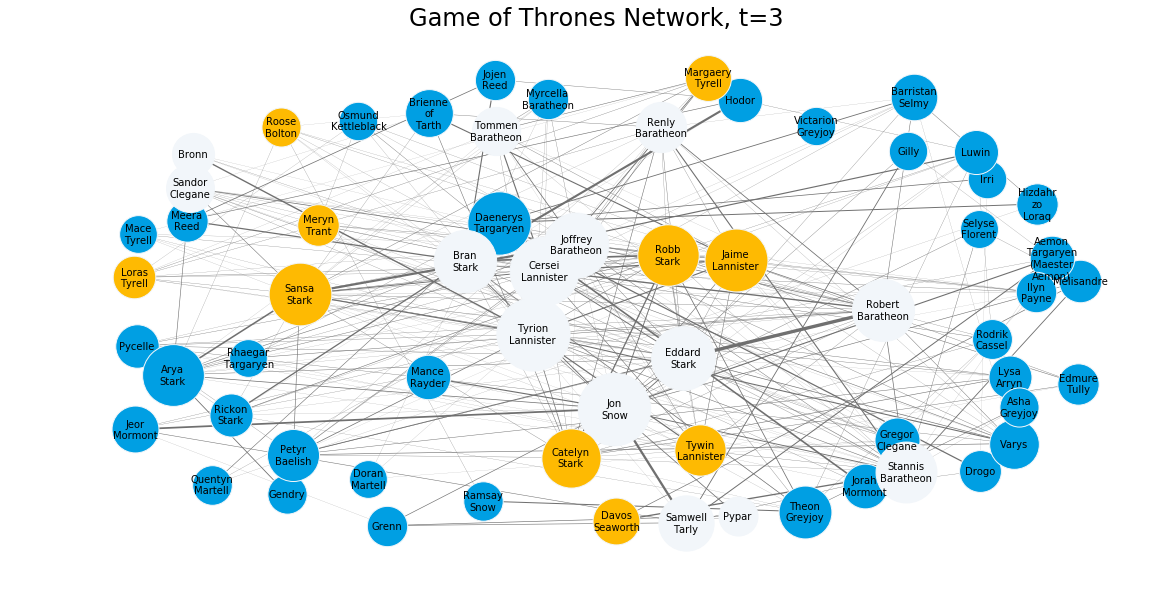

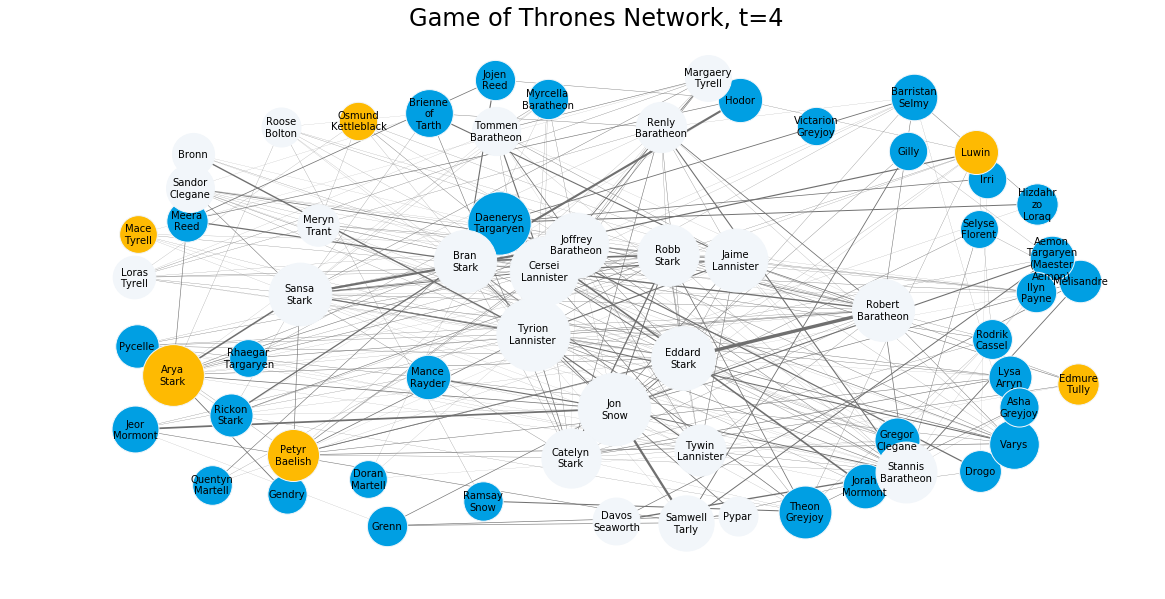

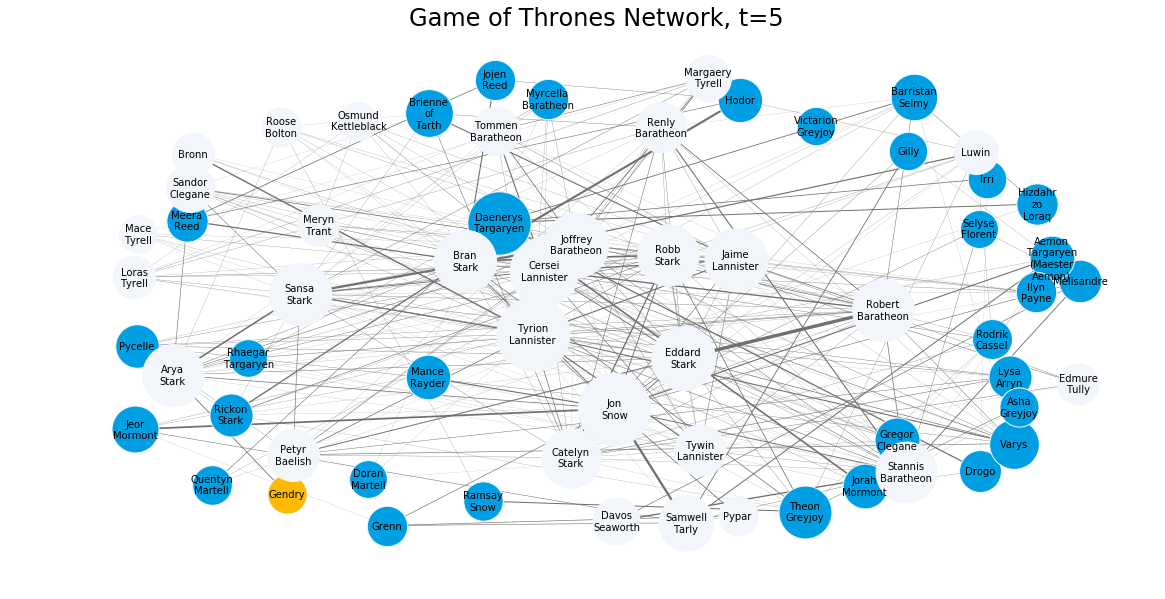

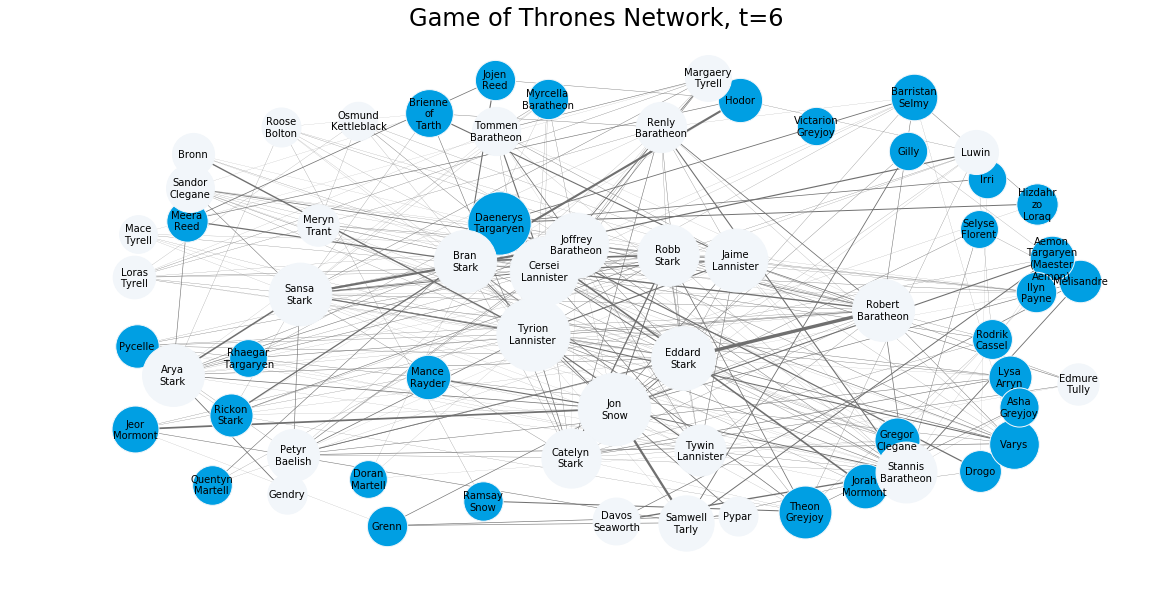

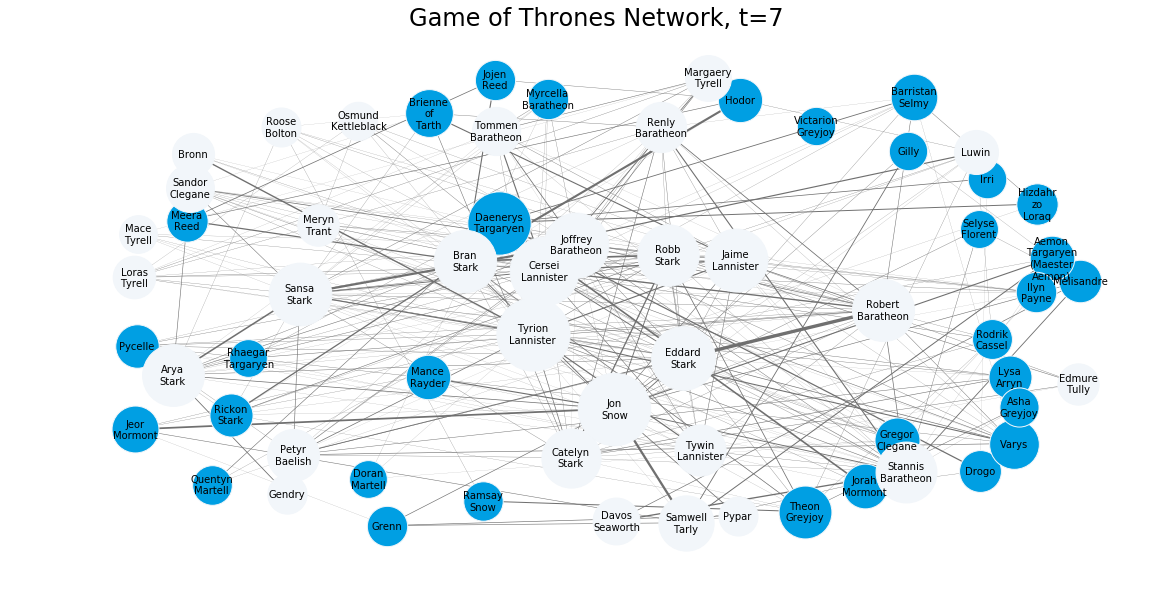

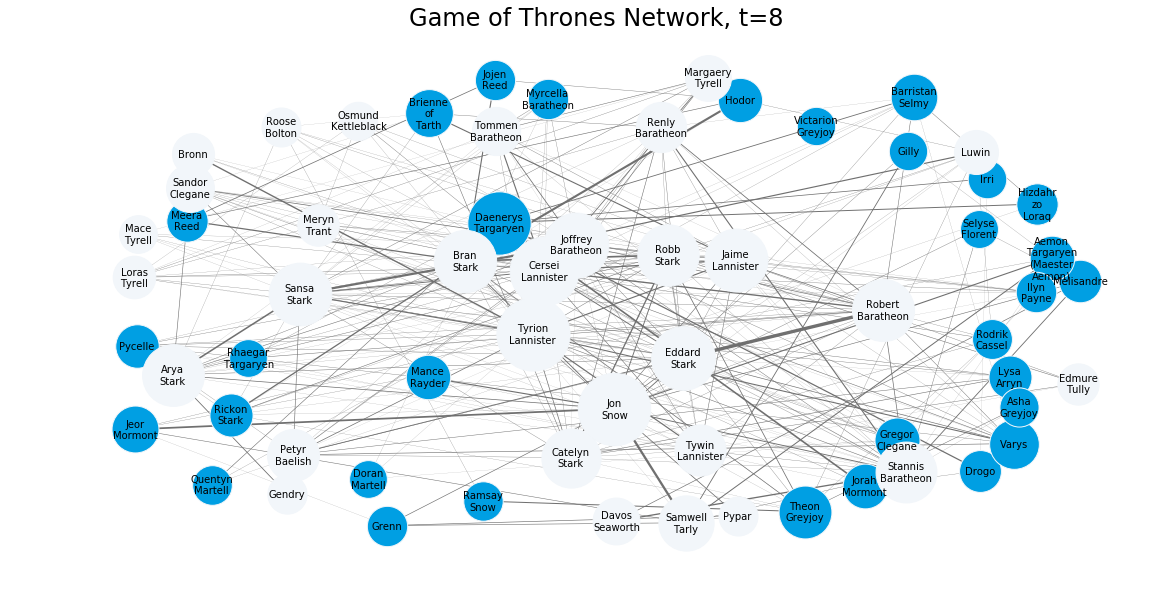

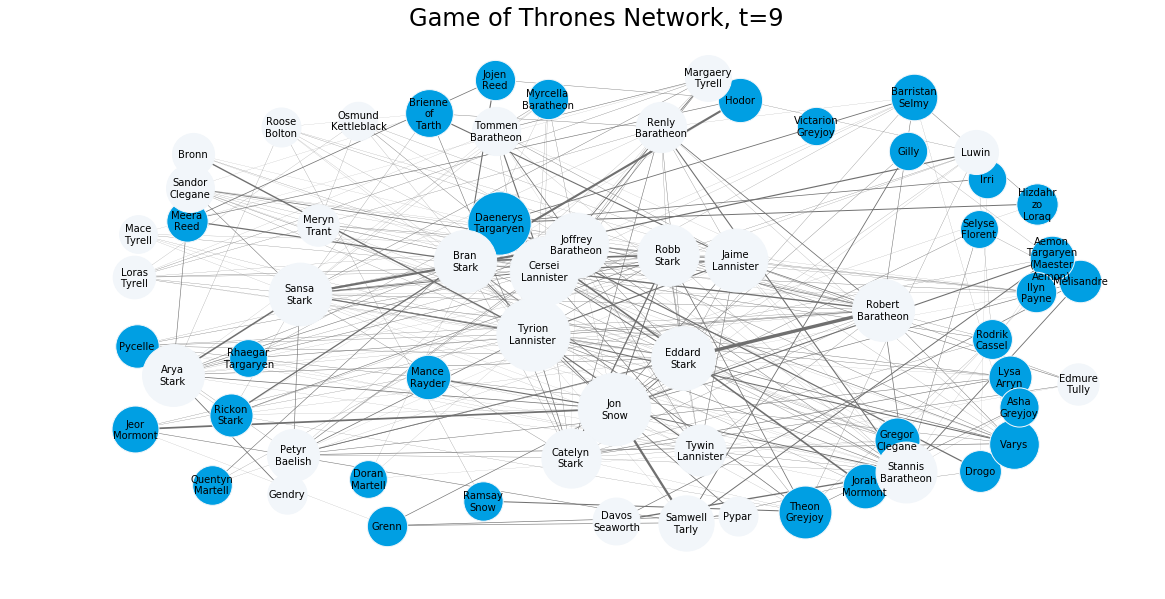

In [20]:
for t in range(10):
    plot_G(subG,pos,infection_times,t)
    infection_times = independent_cascade(subG,t,infection_times)

#### Let's identify infuencers in the networkm

In [21]:
top = pd.DataFrame.from_dict(dict(nx.degree(subG)),orient='index').sort_values(0,ascending=False)
top.columns = ['Degree']
top['Weighted Degree'] =  pd.DataFrame.from_dict(dict(nx.degree(subG,weight='weight')),orient='index')
top['PageRank'] = pd.DataFrame.from_dict(dict(nx.pagerank_numpy(subG,weight='weight')),orient='index')
top['Betweenness'] =  pd.DataFrame.from_dict(dict(nx.betweenness_centrality(subG,weight='weight')),orient='index')

In [22]:
top.head()

Degree  Weighted Degree  PageRank  Betweenness
Tyrion-Lannister       40             1842  0.052710     0.036445
Robert-Baratheon       37             1271  0.037012     0.223912
Joffrey-Baratheon      35             1518  0.042829     0.033051
Cersei-Lannister       34             1627  0.046179     0.004671
Eddard-Stark           34             1330  0.037789     0.024061

In [23]:
methods = top.columns

print(nx.info(subG))
print(nx.info(GOT))

Name: 
Type: SubGraph
Number of nodes: 63
Number of edges: 496
Average degree:  15.7460
Name: 
Type: Graph
Number of nodes: 796
Number of edges: 2823
Average degree:   7.0930


### For different budgets lets compare the centrality metrics for seeding

In [25]:
max_budget = len(subG.nodes())
trials = 50
all_results = []
for budget in tqdm.tqdm_notebook(range(max_budget)):
    results = {'budget':budget}
    for method in methods:
        infections = []
        for i in range(trials):
            infected = 0
            t= 0
            infection_times = {n:0 for n in top.sort_values(method,ascending=False).index[:budget]}
            while len(infection_times)>infected:
                #t+=1
                infected = len(infection_times)
                infection_times = independent_cascade(subG,t,infection_times)
                t+=1
            infections.append(infected)
        results[method] = np.round(np.mean(infections)/len(subG.nodes()),2)

    all_results.append(results)
              

A Jupyter Widget

In [27]:
res_df = pd.concat([pd.DataFrame.from_dict(r,orient='index').T 
                        for r in all_results]).set_index('budget')

In [32]:
res_df.index = res_df.index/len(subG.nodes())

In [36]:
res_df.head()

Weighted Degree  PageRank  Betweenness  Degree
budget                                                  
0.000000             0.00      0.00         0.00    0.00
0.015873             0.49      0.52         0.51    0.50
0.031746             0.50      0.52         0.51    0.53
0.047619             0.51      0.52         0.52    0.50
0.063492             0.54      0.53         0.54    0.51

### Now we'll compare the methods on a plot (percentage of infected network)

Text(0.5,0,u'Seeding Budget (out of graph size)')

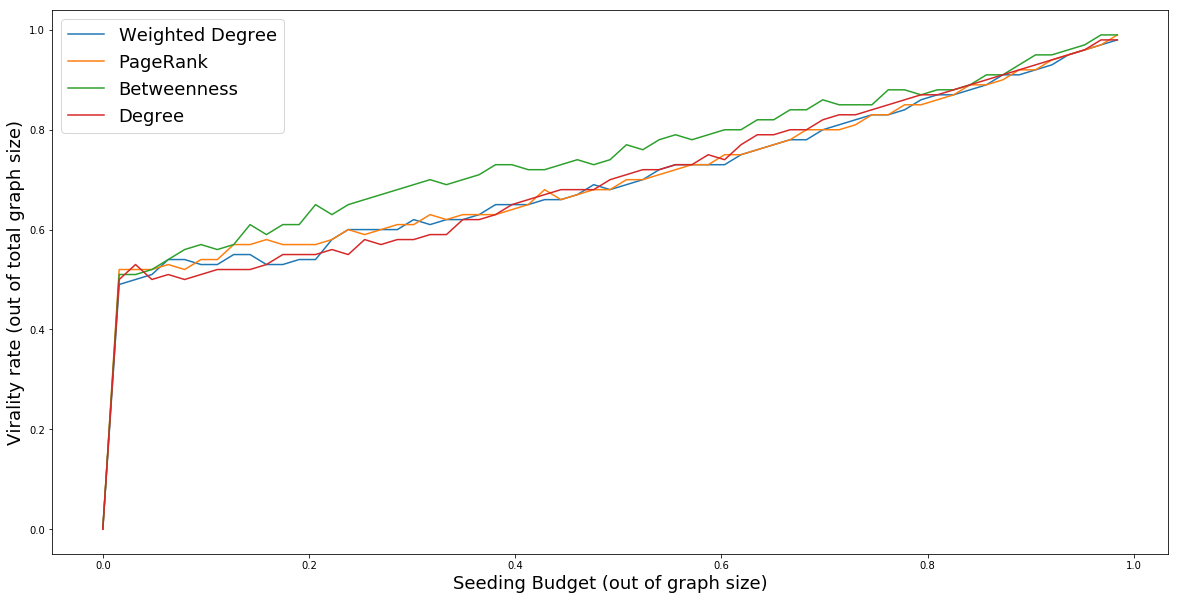

In [34]:
res_df.plot()
plt.legend(fontsize = 18)
plt.ylabel('Virality rate (out of total graph size)',fontsize = 18)
plt.xlabel('Seeding Budget (out of graph size)', fontsize = 18)

### Let's find the best seeding 'couple' (budget = 2) by bruteforce search

In [139]:
from itertools import product

budget=2

seed_sets = list(product(*[subG.nodes()]*budget))

print(len(seed_sets),'Seeding options')

(3969, 'Seeding options')


In [122]:
budget = 2
trials = 20
all_results = []
results = {'budget':budget}
for seed in tqdm.tqdm_notebook(seed_sets[:]):
    infections = []
    for i in range(trials):
        infected = 0
        t= 0
        infection_times = {n:0 for n in seed}
        while len(infection_times)>infected:
            #t+=1
            infected = len(infection_times)
            infection_times = independent_cascade(subG,t,infection_times)
            t+=1
        infections.append(infected)
    results[seed] = np.round(np.mean(infections)/len(subG.nodes()),2)

all_results.append(results)

A Jupyter Widget

In [135]:
sorted(results.items(), key = lambda x: x[1], reverse=True)[:10]

[('budget', 2),
 (('Hizdahr-zo-Loraq', 'Joffrey-Baratheon'), 0.57999999999999996),
 (('Tyrion-Lannister', 'Irri'), 0.57999999999999996),
 (('Drogo', 'Robert-Baratheon'), 0.57999999999999996),
 (('Theon-Greyjoy', 'Sansa-Stark'), 0.56999999999999995),
 (('Cersei-Lannister', 'Doran-Martell'), 0.56999999999999995),
 (('Quentyn-Martell', 'Robb-Stark'), 0.56999999999999995),
 (('Robb-Stark', 'Jorah-Mormont'), 0.56999999999999995),
 (('Hizdahr-zo-Loraq', 'Tyrion-Lannister'), 0.56999999999999995),
 (('Pypar', 'Robert-Baratheon'), 0.56999999999999995)]